In [1]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import time
from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm

In [2]:
#gsparams=galsim.GSParams()
gsparams = galsim.GSParams(kvalue_accuracy=1.e-8,maximum_fft_size=2048*8,maxk_threshold=1.e-6)
#gsparams = galsim.GSParams(maximum_fft_size=2048*8)

In [3]:
def makeGaussian(im, flux=1., gsparams=None):
    im_mom = galsim.hsm.FindAdaptiveMom(im,strict=False)
    if im_mom.moments_status != 0:
        #print im_mom.correction_status
        return False, False, False
    else:
        im_mom_sigma, im_mom_shear = im_mom.moments_sigma*im.scale, im_mom.observed_shape
        im_gaussian = galsim.Gaussian(sigma=im_mom_sigma, flux=flux, gsparams=gsparams)
        #im_gaussian = im_gaussian.shear(g1=im_mom_shear.g1,g2=im_mom_shear.g2)
        return im_gaussian, im_mom_sigma, im_mom_shear


In [4]:
pixel_scale = 0.1 #as/px
lamda = 550 #nm
diameter = 1.2 #m
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)

#image_psf = psf.drawImage(scale=pixel_scale/20.,method='no_pixel') #Fit a Gaussian
#psf_gaussian = makeGaussian(image_psf,gsparams=gsparams)[0]
psf_gaussian = psf #Now a misnomer, make it Airy

given_psf = psf_gaussian.drawImage(scale=pixel_scale/10.,method='no_pixel') #Draw oversampled psf image

#gauss_psfii = psf_gaussian
gauss_psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)


(1098, 1098)


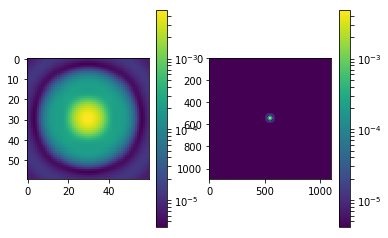

In [5]:
fig,ax=plt.subplots(1,2)
stamp=galsim.ImageF(60,60)
new_image_psf = psf.drawImage(scale=pixel_scale/10.,method='no_pixel',image=stamp)
vmin,vmax=np.min(new_image_psf.array),np.max(new_image_psf.array)
f1=ax[0].imshow(new_image_psf.array,norm=LogNorm(),vmin=vmin,vmax=vmax)
f2=ax[1].imshow(given_psf.array,norm=LogNorm(),vmin=vmin,vmax=vmax)
fig.colorbar(f1,ax=ax[0])
fig.colorbar(f2,ax=ax[1])
print given_psf.array.shape

In [78]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
hlr, sn, q = [np.array([pc[4][i] for pc in cc.param_cat]) for i in range(1,4)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][0:1] #Large galaxies, reasonable sersic n
gal = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)[0]

-9.073273e-11


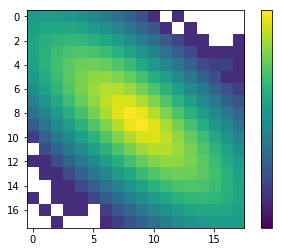

In [79]:
plt.imshow(gal.drawImage(scale=pixel_scale).array,norm=LogNorm())
plt.colorbar()
print np.min(gal.drawImage().array)

In [80]:
# gal = galsim.Sersic(n=0.9,scale_radius = 0.2899613, flux=7.4369873,gsparams=gsparams)
# gal=gal.transform(0.8222,0.260355,0.260355,1.29868)
print gal
orig_gal = gal

galsim.Sersic(n=1.0, half_light_radius=0.108705859505, flux=2.16024879771).shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))


In [82]:
sizes = np.logspace(-1,2,10)[:-1]
errs = []
print sizes
for size in sizes:
    print size
    gal = orig_gal.expand(size)
    fin = galsim.Convolve([gal,psf_gaussian])
    given_im = fin.drawImage(scale=pixel_scale, method='no_pixel')

    #gal_interp = fin
    gal_interp = galsim.InterpolatedImage(given_im,gsparams=gsparams)

    inv_gauss = galsim.Deconvolve(gauss_psfii)
    dec = galsim.Convolve(gal_interp,inv_gauss)
    rec = galsim.Convolve(dec, gauss_psfii)

    recIm = rec.drawImage(scale=pixel_scale,method='no_pixel')

    decIm = dec.drawImage(scale=pixel_scale)
    ss=decIm.array.shape[0]
    stamp=galsim.ImageF(ss,ss)
    # plt.imshow(decIm.array - gal.drawImage(image=stamp,scale=pixel_scale).array)
    # plt.colorbar()

    #fig,ax=plt.subplots(1,2)
    recsize = recIm.array.shape[0]
    origIm = galsim.ImageF(recsize,recsize)
    origIm = fin.drawImage(image=origIm,scale=pixel_scale,method='no_pixel')
    # f1=ax[0].imshow(origIm.array,norm=LogNorm(),vmin=1e-6)
    # f2=ax[1].imshow(recIm.array,norm=LogNorm(),vmin=1e-6)

    # fig.colorbar(f1,ax=ax[0])
    # fig.colorbar(f2,ax=ax[1])

    # plt.imshow(origIm.array / recIm.array - 1,vmin=-2e-3,vmax=2e-3,cmap=cm.bwr)
    # plt.colorbar()

    # plt.imshow((origIm.array - recIm.array)*1e7,vmin=-2,vmax=2,cmap=cm.bwr)
    # plt.colorbar()

    #print np.max(np.abs(origIm.array - recIm.array))

    orig_shape=galsim.hsm.FindAdaptiveMom(origIm).observed_shape
    #print orig_shape.e1, orig_shape.e2

    rec_shape=galsim.hsm.FindAdaptiveMom(recIm).observed_shape
    #print rec_shape.e1, rec_shape.e2

    e1err,e2err= 1-rec_shape.e1/orig_shape.e1, 1-rec_shape.e2/orig_shape.e2
    errs.append((e1err,e2err))


[ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.         21.5443469  46.41588834]
0.1
0.21544346900318834
0.46415888336127786
1.0
2.1544346900318834
4.6415888336127775
10.0
21.54434690031882
46.41588833612777


In [83]:
print errs

[(-0.09434865140334381, 0.20105721693317036), (0.01786996394535345, 0.19517926315195233), (0.03244853837343886, 0.11584877157597162), (0.03699482272041266, 0.0194814213260448), (0.004029721979458167, 0.0014547724628560799), (0.00013628483878991293, 4.659936839557233e-05), (2.5374809191625047e-06, 7.914344003490115e-07), (8.367015436050451e-08, 0.0), (-2.4985668645172154e-07, -2.220446049250313e-16)]


In [84]:
e1errs = np.abs(np.array([err[0] for err in errs]))
e2errs = np.abs(np.array([err[1] for err in errs]))

In [85]:
print sizes

[ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.         21.5443469  46.41588834]


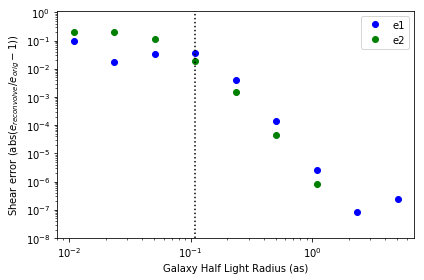

In [93]:
hlr = 0.109
newsizes = sizes * hlr
fig,ax=plt.subplots()
plt.plot(newsizes,e1errs,'bo',label='e1')
plt.plot(newsizes,e2errs,'go',label='e2')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Galaxy Half Light Radius (as)')
plt.ylabel('Shear error (abs($e_{reconvolve}/e_{orig}-1$))')
plt.legend()
plt.ylim(1e-8)
plt.axvline(hlr,c='k',linestyle=':')
plt.tight_layout()
plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/shearerror_vs_galsize.png')

In [48]:
e2errs

array([2.01057497e-01, 1.91825878e-01, 8.25966438e-02, 8.07883775e-03,
       2.89680310e-04, 3.82690098e-06, 7.84381521e-08, 7.79602420e-08])